## Demonstration of Audio Denoising

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from scipy.signal import decimate
from librosa import stft, istft

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def load_example(path, n_fft=256, hop_length=64):
    
    # read and resample audiofile
    y, fs = sf.read(path)
    y = decimate(y, 2)
    fs = fs // 2
    y = y/np.max(np.abs(y[:]))

    # add background noise to signal
    #n, _ = sf.read('../data/Sprecheraufnahmen_Complete_Project/Sprecher/Prof_Speaker_male/Prof_Speaker_male_Froschk”nig.wav')
    n, _ = sf.read('../data/babble_noise.wav')
    n = n[:,0]
    n = np.concatenate((n,n,n,n))
    n = decimate(n, 2)
    #n = np.random.normal(size=y.shape)
    x = y + .5 * n[:len(y)]
    sf.write('noisy.wav', x, int(fs))

    # STFT of reference signal
    Y = stft(y, n_fft=n_fft, hop_length=hop_length).T
    angle = np.angle(Y)
    Y = np.abs(Y)

    # STFT of noisy signal
    X = stft(x, n_fft=n_fft, hop_length=hop_length).T
    X = np.abs(X)
    X = X/np.max(X[:])

    return X, Y, angle, fs

X, Y, angle, fs = load_example('../data/froschkoenig_female_speaker.wav')

In [3]:
nseg = 8

Y = Y[nseg-1:,:]

X = [X[n:n+nseg, :] for n in range(len(Y))]
X = np.array(X)

In [22]:
def dnn_model(input_shape=(8, 129)):

    inputs = Input(shape=input_shape)

    x = Dense(1024)(inputs)
    x = Activation('relu')(x)

    x = Dense(1024)(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    x = Dense(129, activation='relu')(x)

    return Model(inputs, x)



from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Normalization

normalizer = Normalization()


def cnn_model(input_shape=(8, 129, 1)):

    inputs = Input(shape=input_shape)
    
    x = normalizer(inputs)

    x = Conv2D(16, (5,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(16, (4,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(32, (1,9), strides=(1,2))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(32, (1,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(32, (1,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(64, (1,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(64, (1,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(64, (1,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(64, (1,9))(x)
    x = Activation('relu')(x)
    
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,5))(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    x = Dense(129, activation='relu')(x)

    return Model(inputs, x)


model = cnn_model()
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 8, 129, 1)]       0         
                                                                 
 normalization (Normalizatio  (None, 8, 129, 1)        3         
 n)                                                              
                                                                 
 conv2d_112 (Conv2D)         (None, 4, 121, 16)        736       
                                                                 
 activation_110 (Activation)  (None, 4, 121, 16)       0         
                                                                 
 batch_normalization_92 (Bat  (None, 4, 121, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_113 (Conv2D)         (None, 1, 113, 16)        923

In [23]:
model.compile(loss="mse", optimizer="adam")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

normalizer.adapt(X_train)

callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X, Y, validation_data=(X_test, Y_test), callbacks=[callback], epochs=200, batch_size=64)

Epoch 1/200
781/781 [==============================] - 37s 47ms/step - loss: 0.4850 - val_loss: 0.3453
Epoch 2/200
781/781 [==============================] - 37s 48ms/step - loss: 0.1312 - val_loss: 0.1601
Epoch 3/200
781/781 [==============================] - 39s 50ms/step - loss: 0.1098 - val_loss: 0.1060
Epoch 4/200
781/781 [==============================] - 37s 48ms/step - loss: 0.0990 - val_loss: 0.1065
Epoch 5/200
781/781 [==============================] - 38s 48ms/step - loss: 0.0932 - val_loss: 0.0966
Epoch 6/200
781/781 [==============================] - 38s 48ms/step - loss: 0.0869 - val_loss: 0.1029
Epoch 7/200
781/781 [==============================] - 38s 49ms/step - loss: 0.0835 - val_loss: 0.0950
Epoch 8/200
781/781 [==============================] - 38s 49ms/step - loss: 0.0801 - val_loss: 0.0829
Epoch 9/200
781/781 [==============================] - 40s 51ms/step - loss: 0.0755 - val_loss: 0.0666
Epoch 10/200
781/781 [==============================] - 37s 47ms/step - l

Epoch 80/200
781/781 [==============================] - 37s 48ms/step - loss: 0.0311 - val_loss: 0.0273
Epoch 81/200
781/781 [==============================] - 38s 48ms/step - loss: 0.0304 - val_loss: 0.0272
Epoch 82/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0305 - val_loss: 0.0277
Epoch 83/200
781/781 [==============================] - 38s 48ms/step - loss: 0.0307 - val_loss: 0.0368
Epoch 84/200
781/781 [==============================] - 37s 48ms/step - loss: 0.0304 - val_loss: 0.0279
Epoch 85/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0302 - val_loss: 0.0279
Epoch 86/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0300 - val_loss: 0.0270
Epoch 87/200
781/781 [==============================] - 37s 48ms/step - loss: 0.0295 - val_loss: 0.0304
Epoch 88/200
781/781 [==============================] - 36s 46ms/step - loss: 0.0301 - val_loss: 0.0288
Epoch 89/200
781/781 [==============================] - 37s 47ms

781/781 [==============================] - 37s 47ms/step - loss: 0.0242 - val_loss: 0.0204
Epoch 159/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0241 - val_loss: 0.0221
Epoch 160/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0240 - val_loss: 0.0233
Epoch 161/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0240 - val_loss: 0.0229
Epoch 162/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0236 - val_loss: 0.0209
Epoch 163/200
781/781 [==============================] - 36s 46ms/step - loss: 0.0237 - val_loss: 0.0205
Epoch 164/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0236 - val_loss: 0.0233
Epoch 165/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0237 - val_loss: 0.0229
Epoch 166/200
781/781 [==============================] - 37s 47ms/step - loss: 0.0238 - val_loss: 0.0205
Epoch 167/200
781/781 [==============================] - 39s 50ms/ste

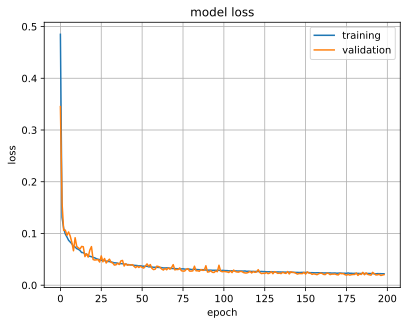

In [24]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')

In [25]:
X_test, Y_test, angle_test, fs = load_example('../data/single_words_female_speaker.wav')

Y_test = Y_test[nseg-1:,:]
angle_test = angle_test[nseg-1:,:]

X_test = [X_test[n:n+nseg, :] for n in range(len(Y_test))]
X_test = np.array(X_test)


Yr_test = model.predict(X_test)
yr_test = istft(Yr_test.T * np.exp(1j*angle_test).T)
yr_test = yr_test / np.max(np.abs(yr_test[:]))

sf.write('reconstructed.wav', yr_test, int(fs))